# Interactive Nestle Demo

This is a simple interactive demo (following the [example](http://kylebarbary.com/nestle/examples/plot_shells.html#sphx-glr-examples-plot-shells-py) in the documentation) that briefly goes over nested sampling, its implementation in `Nestle`, and our improvements for Prospector.

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import concurrent

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Nested Sampling: Background

In standard Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

Nested sampling attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within **iso-likelihood contours** at $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $0 < X_N < \dots < X_i < \dots < X_1 < X_0 < 1$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## Nested Sampling: How It Works

We start with a number of $N_{\textrm{live}}$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we then remove the live point with the lowest likelihood $\mathcal{L}_i$ and corresponding prior volume $X_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} > \mathcal{L}_i$. It can be shown through some neat statistical arguments that this sampling procedure actually allows us to approximate the prior volume based on the current iteration as

$$ \ln X_i \approx -i/N_{\textrm{live}} $$

where we've ignored some uncertainties for clarity. Given that we compute $\mathcal{L}_i$ when moving to this live point in the first place, this actually enables us to directly estimate the evidence as using a set of $N$ samples via

$$ \mathcal{Z} \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \mathcal{L}_i w_i $$

where $w_i$ is the **importance weight**. For a simple trapezoidal integration scheme (most commonly used), $w_i = \frac{1}{2} (X_{i-1} - X_{1+1})$.

### Termination

The remaining prior volume $\Delta \mathcal{Z}_i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multipled by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This error estimate often serves as a threshold that can be used for deciding when to terminate sampling.

### Sampling

The main requirements for nested sampling to work are:
1. that all samples used to compute/kill/replace live points are independent and
2. that all samples are drawn in proportion to the prior.

The first requirement is often not too difficult to satisfy. The second, however, is much harder to satisfy in cases where the prior is not uniform. Most nested sampling algorithms/packages (including `Nestle`) thus sample on the unit cube, which requires that you are able to transform your priors to be uniform (i.e. compute their inverse CDF).

Assuming that 1. and 2. are be satisfied, the main challenge of most nested sampling implementations is coming up with ways to draw a new point as uniformly as possible without spending too much time sampling outside the prior volume. These tend to break down into two schemes: random walking away from the current set of live points or attempting to enclose the prior volume contained by all live points. The latter tends to be more popular.

## Test Case: Gaussian Shells

Let's give `Nestle` a test run over a set of Gaussian shells.

In [2]:
import nestle

In [3]:
# Gaussian shells likelihood

# circle/shell function
def logcirc(theta, c):
    d = sqrt(sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2) # log-circ

# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

We now need to define the transformation that takes our uniform samples and transforms them back to the variables of interest.

In [4]:
# prior transform
def prior_transform(x):
    """Defines a flat prior between -6 and 6 in all dimensions."""
    return 12. * x - 6.

Now let's run `Nestle`!

In [5]:
# nested sampling results
f = lambda theta: loglike(theta, c1, c2)
res = nestle.sample(f, prior_transform, 2, method='multi', npoints=1000)

Let's now plot our results.

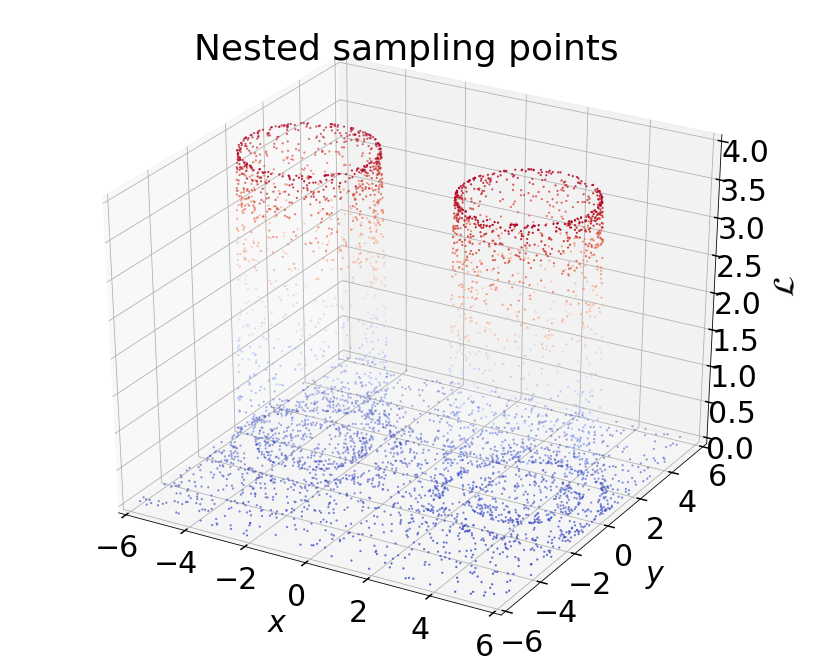

In [6]:
fig = figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(res.samples[:, 0], res.samples[:, 1], exp(res.logl),
           marker='.', c=exp(res.logl), linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-6., 6.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-6., 6.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(0., 4.)
ax.set_zlabel(r'$\mathcal{L}$', labelpad=25)
ax.set_title('Nested sampling points')
tight_layout()

Let's see how our performance scales with dimensionality here.

In [7]:
npoints = 1000

# run nestle for ndim Gaussian shells
def run(ndim):
    """Convenience function for running in any dimension"""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Ndim={0}...".format(ndim))
    return nestle.sample(f, prior_transform, ndim, method='multi', npoints=npoints)

In [8]:
from collections import OrderedDict

dims = array([2, 5, 10, 20]) # dimensions to sample

# analytic log-evidence values
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09} 
                 #30: -60.13}
                 #50: -112.42}

# compute results
results = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results[ndim] = run(ndim)
    results[ndim].time = time.time() - t0
sys.stdout.write("\n")

Ndim=2...Ndim=5...Ndim=10...Ndim=20...


Let's take a look at our results.

In [9]:
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in results.items():
    eff = 100. * res.niter / (res.ncall - npoints)
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz, res.logzerr,
                  res.ncall, eff, res.time))

D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.73     0.05   11609   37.99    1.46
 5    -5.67   -5.80     0.08   23836   35.47    3.29
10   -14.59  -14.45     0.12   48548   35.22    5.16
20   -36.09  -35.51     0.19  177889   21.37   26.12


## Parallelization

One of our changes to the default Nestle code is proposing points in parallel using `ThreadPoolExecutor`. This allows us to independently task a number of threads with finding good trial points that we can check as we go.

In [10]:
import pnestle

Parallelization works better when the likelihood calls are expensive and you're not guaranteed to accept the results, making it computationally more expedient to try a bunch of points rather than one at a time. We'll put this in by hand here.

In [11]:
# log-likelihood function
def loglike(theta, c1, c2):
    time.sleep(1e-3)
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

In [12]:
# run nestle for ndim Gaussian shells
def parallel_run(ndim, nthreads, pool):
    """Convenience function for running in any dimension with multiple threads."""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Nthreads={0}...".format(nthreads))
    return pnestle.sample(f, prior_transform, ndim, method='multi', npoints=npoints, 
                          n_threads=nthreads, pool=pool)

In [13]:
threads = array([1, 2, 4, 8, 16])
ndim = 5

# compute results
results = OrderedDict()
for nthreads in threads:
    t0 = time.time()
    with concurrent.futures.ThreadPoolExecutor(nthreads) as pool:
        results[nthreads] = parallel_run(ndim, nthreads, pool)
    results[nthreads].time = time.time() - t0
sys.stdout.write("\n")

Nthreads=1...Nthreads=2...Nthreads=4...Nthreads=8...Nthreads=16...


Let's now see how we're doing.

 D  N  analytic    logz  logzerr   nlike  eff(%)   time
 5   1    -5.67   -5.64     0.08   24163   34.28   33.11
 5   2    -5.67   -5.58     0.08   23898   34.40   17.55
 5   4    -5.67   -5.77     0.08   24181   34.84   10.17
 5   8    -5.67   -5.52     0.08   23120   35.37    7.19
 5  16    -5.67   -5.67     0.08   27629   29.91    7.96


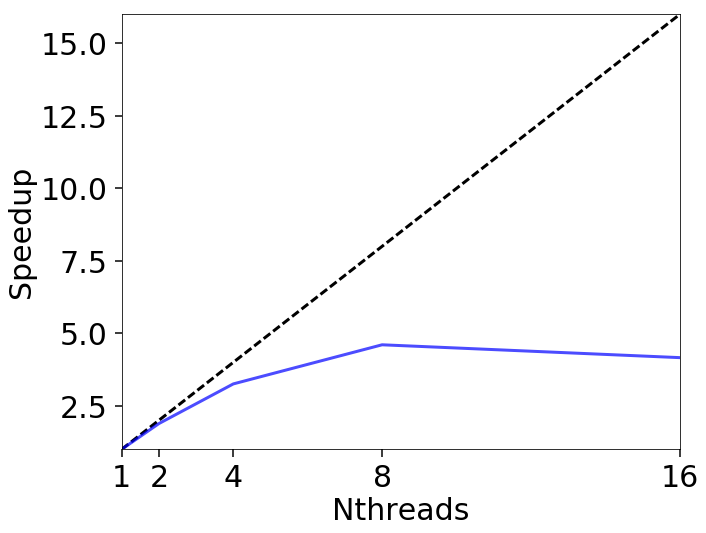

In [15]:
print(" D  N  analytic    logz  logzerr   nlike  eff(%)   time")
for nthreads, res in results.items():
    eff = 100. * res.niter / (res.ncall - npoints)
    print("{:2d}  {:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, nthreads, analytic_logz[ndim], res.logz, res.logzerr,
                  res.ncall, eff, res.time))
    
times = array([res.time for nthreads, res in results.items()])
speedup = times[0] / times

figure(figsize=(10,8))
plot([1, max(threads)], [1, max(threads)], color='black', ls='--', lw=3)
plot(threads, speedup, color='blue', lw=3, alpha=0.7)
xlim([1, max(threads)])
ylim([1, max(threads)])
xlabel('Nthreads')
xticks(threads)
ylabel('Speedup')

The falloff at $N>4$ cores here is specific to the machine I'm running these tests on, which only has 4 cores.